## Import

In [5]:
%load_ext autoreload
%autoreload 2
#import datetime
import glob
import logging
import os
import platform
import pprint

import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import sklearn

import helpers.config as cfg
import helpers.dbg as dbg
import core.explore as exp
import core.finance as fin
import helpers.printing as printing
import core.features_analyzer as ana
import vendors.particle_one.utils as put
import vendors.kibot.utils as kut

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
print(cfg.get_system_signature())

printing.config_notebook()

# TODO(gp): Changing level during the notebook execution doesn't work. Fix it.
#dbg.init_logger(verb=logging.DEBUG)
dbg.init_logger(verb=logging.INFO)
#dbg.test_logger()

_LOG = logging.getLogger(__name__)

python=3.7.1
numpy=1.15.4
pandas=0.24.1
seaborn=0.9.0
scipy=1.2.1
matplotlib=3.0.3
sklearn=0.20.3


# Config

In [7]:
config = {
    "feature_file_name":
    "/Users/saggese/GoogleDrive/alphamatic/Particle/Tech/twitter_dataset_sentiment_07.05.19.csv",
    #
    "feat_zscore_com": 28,
    #
}

if True:
    config.update({
        "agg_interval":
        "1T",
        #"agg_interval": "5T",
        "agg_function":
        "mean",
        #
        "rets_file_name":
        "/Users/saggese/src/lemonade/vendors/particle_one/oil_1min_zrets.csv",
    })
else:
    config.update({
        # TODO(gp): weekday
        "agg_interval":
        "1B",
        "agg_function":
        "mean",
        #
        "rets_file_name":
        "/Users/saggese/src/lemonade/vendors/particle_one/oil_daily_zrets.csv",
    })

_LOG.info("config=\n%s", cfg.config_to_string(config))

config=
feature_file_name: /Users/saggese/GoogleDrive/alphamatic/Particle/Tech/twitter_dataset_sentiment_07.05.19.csv
feat_zscore_com: 28
agg_interval: 1T
agg_function: mean
rets_file_name: /Users/saggese/src/lemonade/vendors/particle_one/oil_1min_zrets.csv


# Read data

In [8]:
feat_data = put.read_data_from_config(config)

_LOG.info("feat_data=\n%s", feat_data.head(3))

Reading data ...
Reading file_name='/Users/saggese/GoogleDrive/alphamatic/Particle/Tech/twitter_dataset_sentiment_07.05.19.csv'
Data is in [2014-12-31 17:20:01, 2019-05-30 22:17:56]
feat_data=
                      demand+   demand-  inventory+  inventory-   supply+   supply-
datetime                                                                           
2014-12-31 17:20:01  0.373282  0.000219    0.005075    0.000257  0.617711  0.003456
2014-12-31 18:02:08  0.003446  0.001197    0.000304    0.006955  0.571811  0.416287
2014-12-31 18:08:12  0.000009  0.000015    0.000008    0.000871  0.530765  0.468331


## Plot time distribution

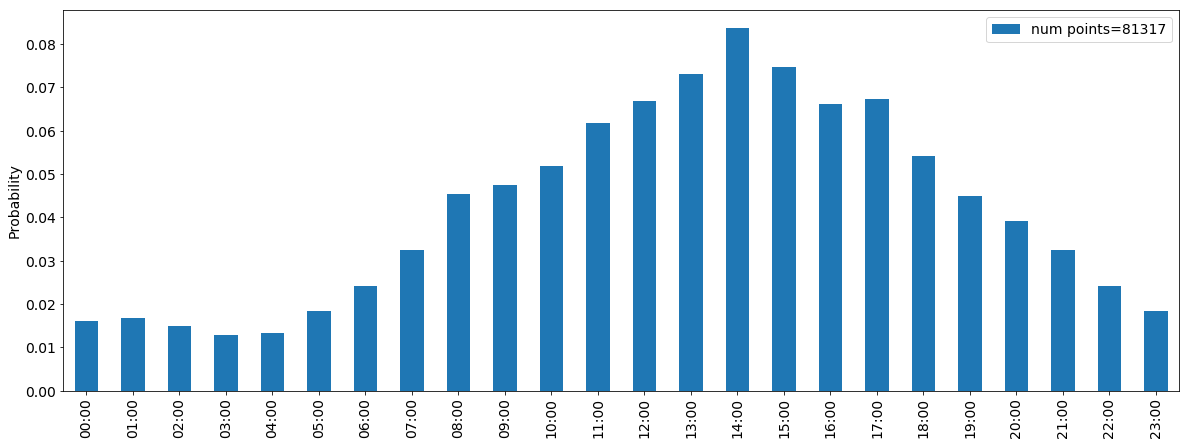

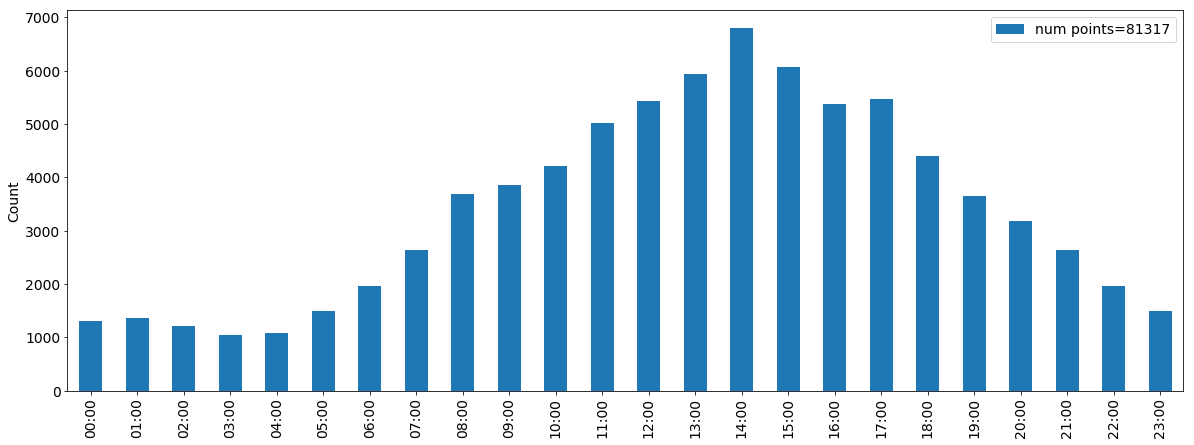

In [9]:
mode = "time_of_the_day"
exp.plot_time_distributions(feat_data.index, mode)
plt.show()
exp.plot_time_distributions(feat_data.index, mode, density=False)

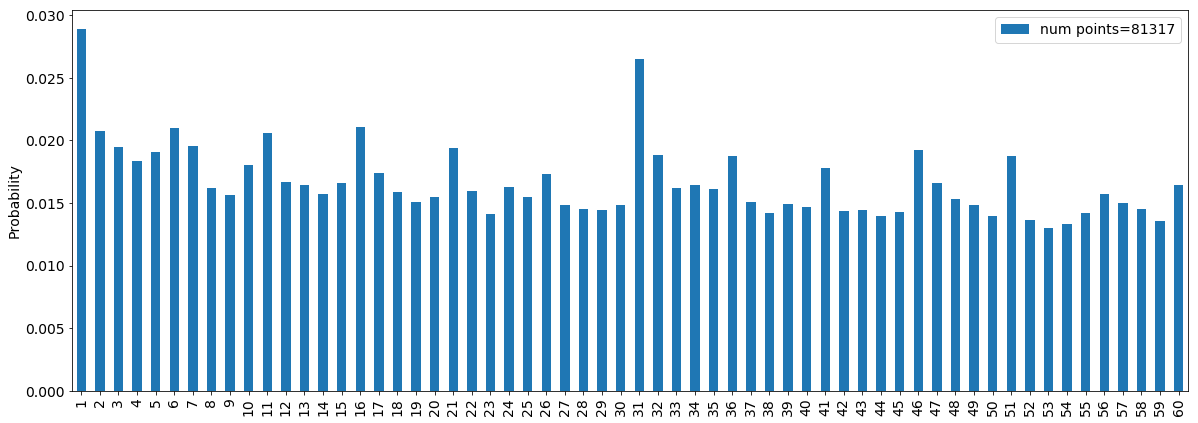

In [10]:
mode = "minute_of_the_hour"
exp.plot_time_distributions(feat_data.index, mode)

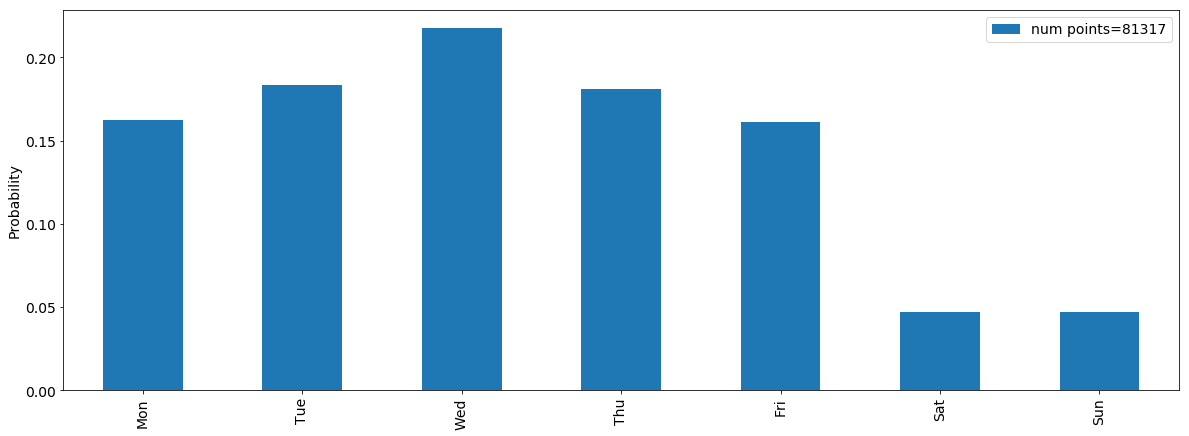

In [11]:
mode = "weekday"
exp.plot_time_distributions(feat_data.index, mode)

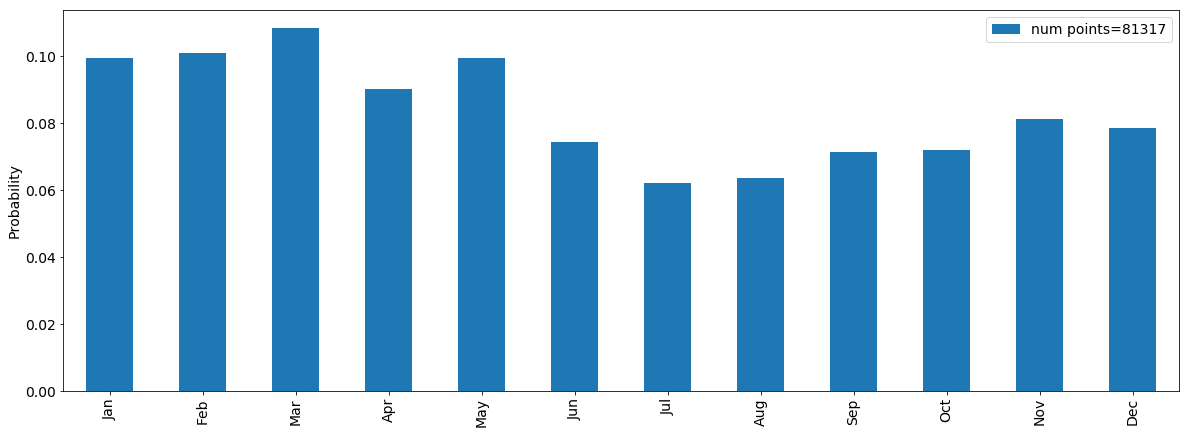

In [12]:
#mode = "day_of_the_month"
mode = "month_of_the_year"
exp.plot_time_distributions(feat_data.index, mode)

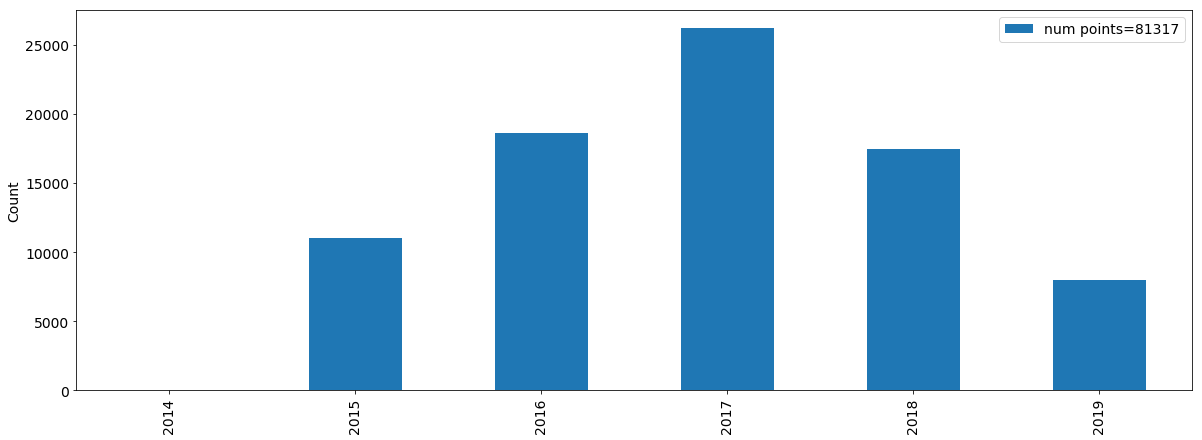

In [13]:
#mode = "day_of_the_month"
mode = "year"
exp.plot_time_distributions(feat_data.index, mode, density=False)

## Plot distribution.

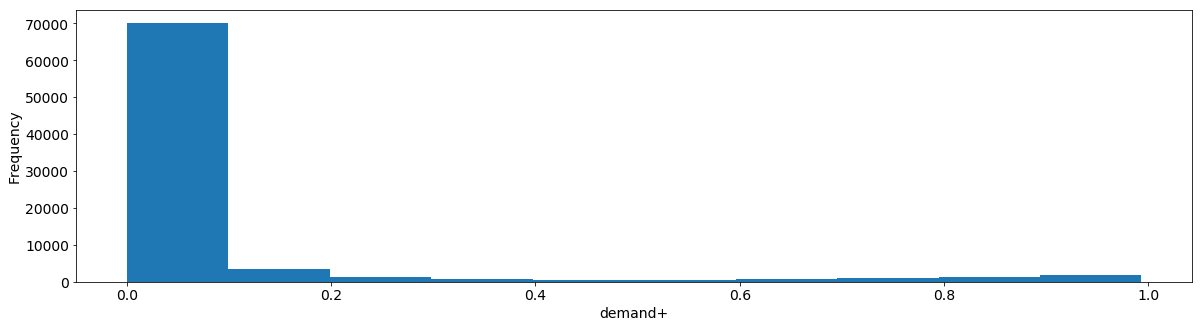

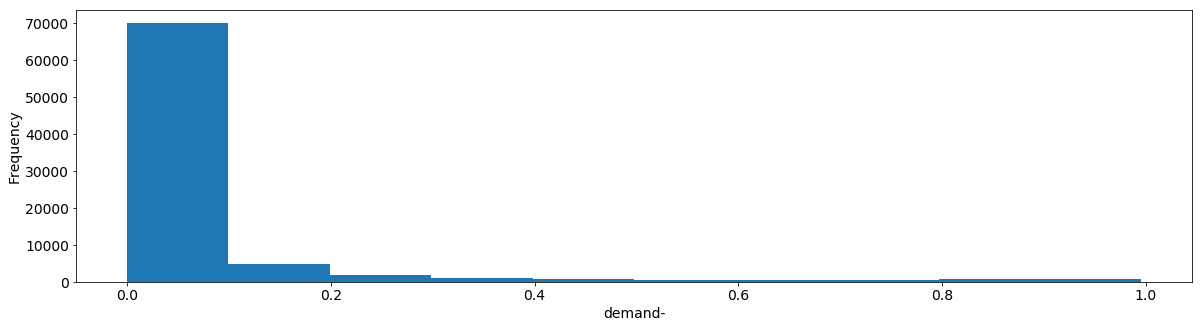

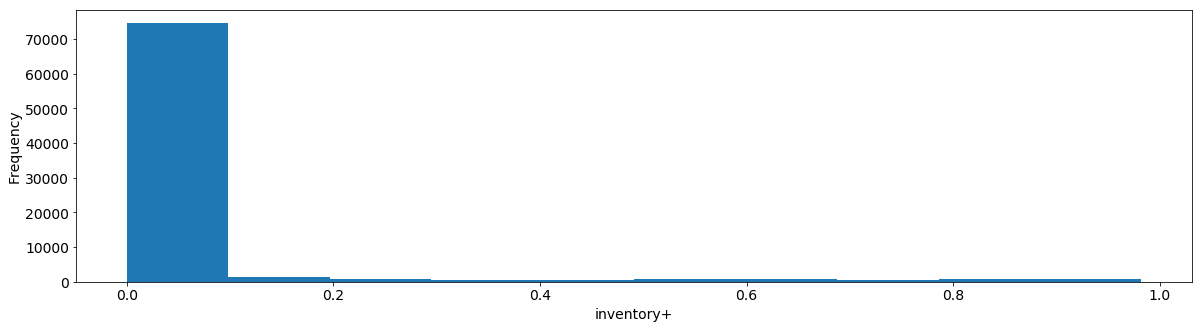

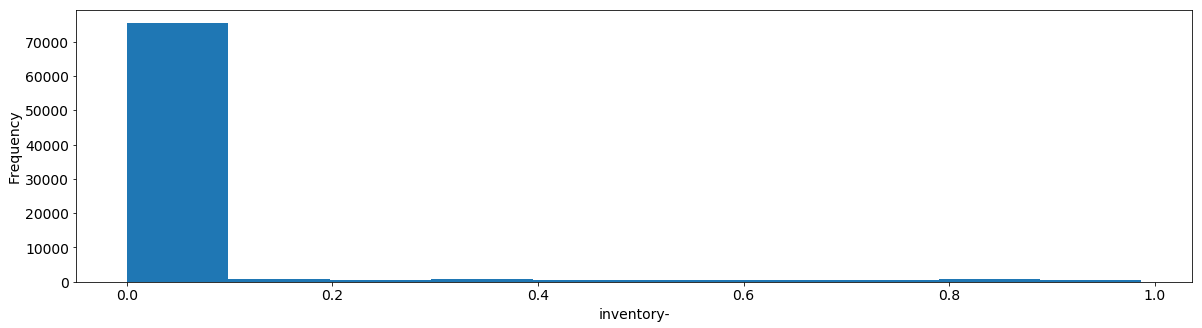

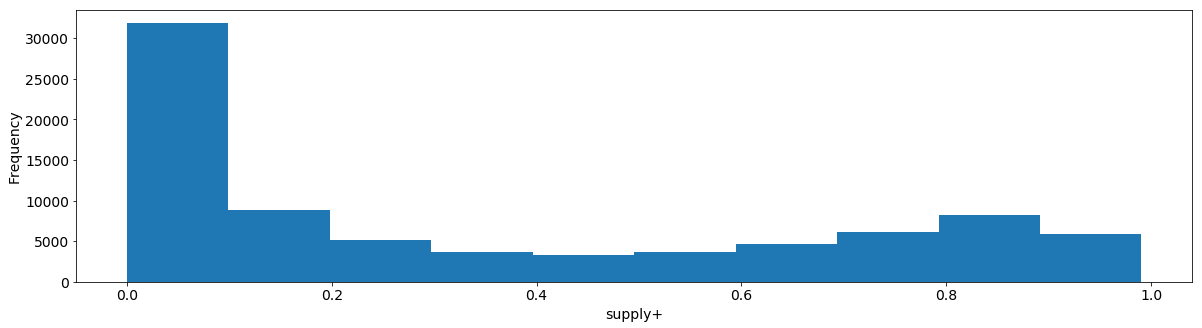

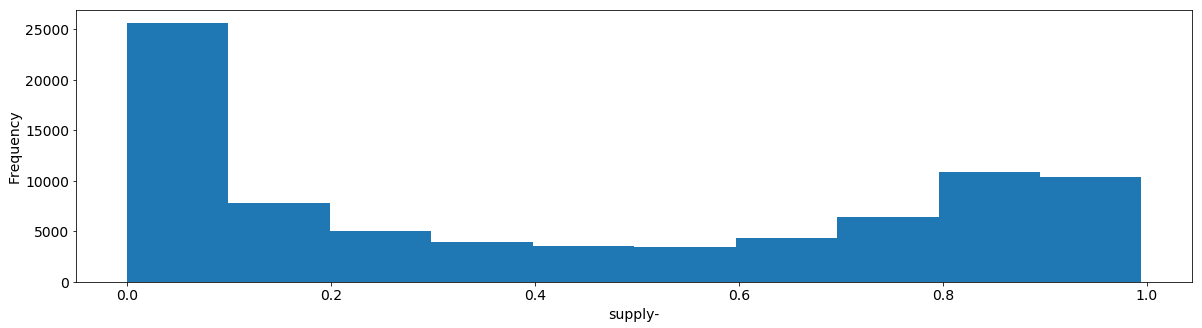

In [14]:
put.plot_raw_data_pdf(feat_data, put.get_raw_features())

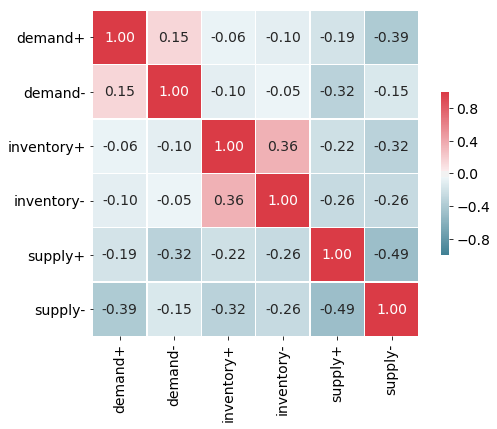

In [15]:
exp.plot_heatmap(feat_data.corr(), "heatmap", annot=True, vmin=-1, vmax=1.0)

## Compute features

In [16]:
# Resample to 1 minute
# - sum()
# - mean()

# Build signal
# - test each component by itself
# - test difference of each component D+ - D-
# - test (S+ - S-) - (D+ - D-) + (I+ - I-)

In [17]:
feat_data, new_features = put.compute_features_from_config(config, feat_data)

all_features = put.get_raw_features() + new_features
_LOG.info("all_features=%s", all_features)
_LOG.info("feat_data=\n%s", feat_data.head(3))

all_features=['demand+', 'demand-', 'inventory+', 'inventory-', 'supply+', 'supply-', 'majority1', 'demand', 'inventory', 'supply', 'majority2']
feat_data=
                      demand+   demand-  inventory+  inventory-   supply+   supply- majority1    demand  inventory    supply majority2
datetime                                                                                                                              
2014-12-31 17:20:01  0.373282  0.000219    0.005075    0.000257  0.617711  0.003456   supply+  0.373064   0.004819  0.614255    supply
2014-12-31 18:02:08  0.003446  0.001197    0.000304    0.006955  0.571811  0.416287   supply+  0.002249  -0.006652  0.155525    supply
2014-12-31 18:08:12  0.000009  0.000015    0.000008    0.000871  0.530765  0.468331   supply+ -0.000006  -0.000863  0.062435    supply


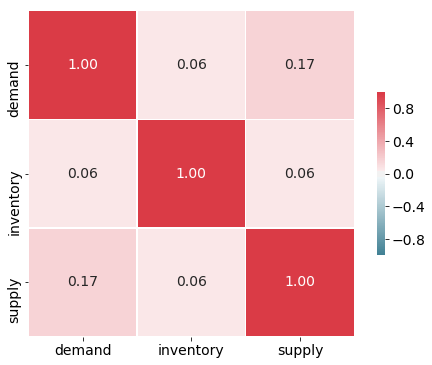

In [18]:
feat_names = "demand inventory supply".split()
exp.plot_heatmap(
    feat_data[feat_names].corr(), "heatmap", annot=True, vmin=-1, vmax=1.0)

In [19]:
# Count majority1 and majority2.

## Sample

In [20]:
feat_data_sampled = put.sample_features_from_config(config, feat_data)

feat_data_sampled.head(2)

,demand+,demand-,inventory+,inventory-,supply+,supply-,demand,inventory,supply
datetime,,,,,,,,,
2014-12-31 17:21:00,0.373282,0.000219,0.005075,0.000257,0.617711,0.003456,0.373064,0.004819,0.614255
2014-12-31 17:22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


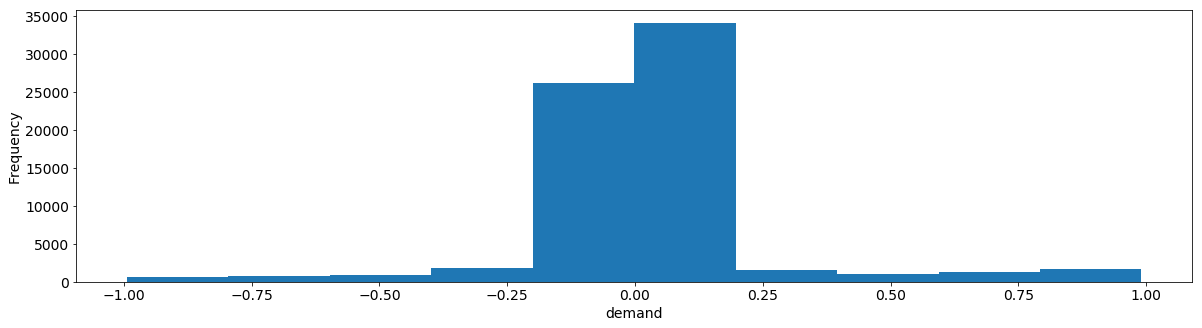

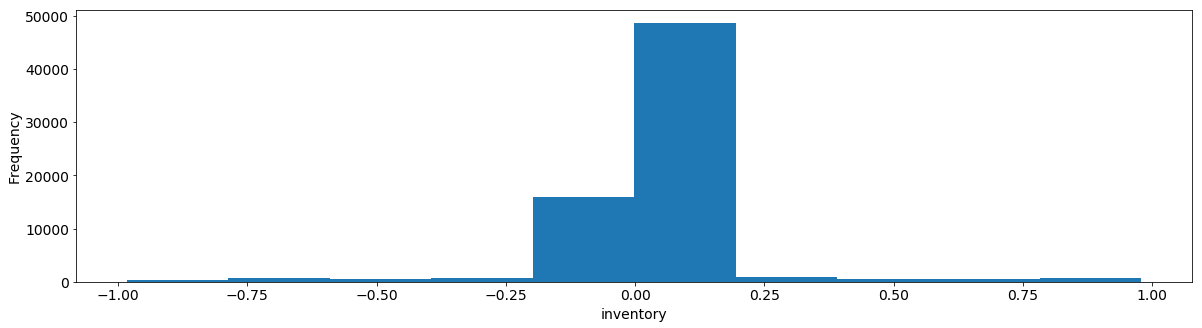

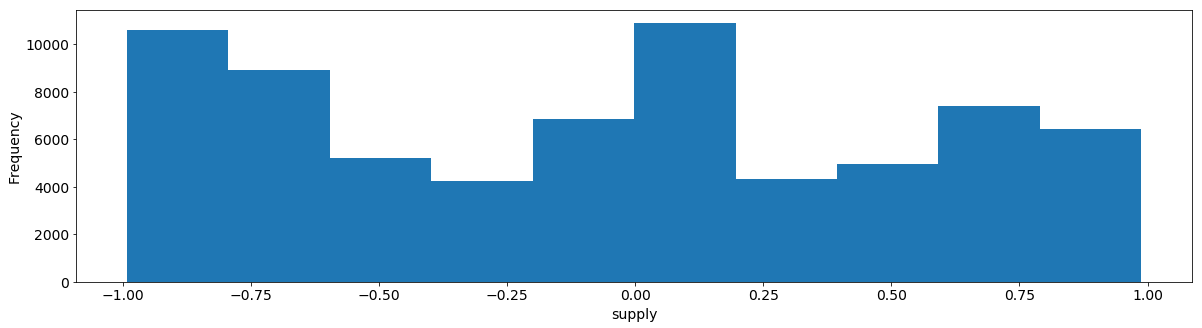

In [21]:
#feat_names = put.get_raw_features() + "demand inventory supply".split()
feat_names = "demand inventory supply".split()
put.plot_raw_data_pdf(feat_data_sampled, feat_names)

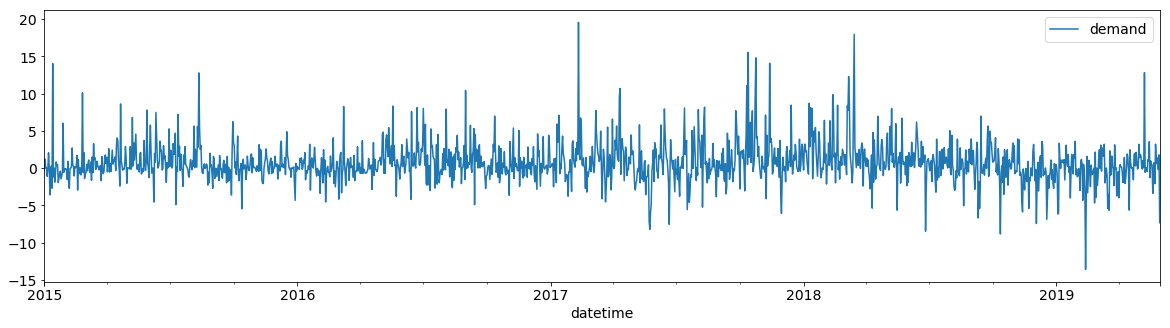

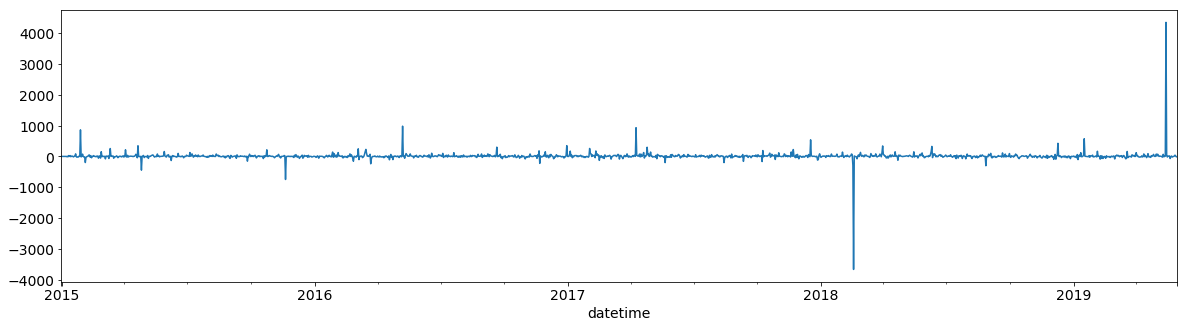

In [22]:
feat_data_sampled[["demand"]].resample("1D").sum().plot()
plt.show()

fin.zscore(
    feat_data_sampled["demand"],
    com=config["feat_zscore_com"],
    demean=True,
    standardize=True,
    delay=1).resample("1D").sum().plot()

# Read returns

In [61]:
_LOG.info("Reading csv '%s'", config["rets_file_name"])
rets = pd.read_csv(config["rets_file_name"], index_col=0, parse_dates=True)

exp.display_df(rets)

Reading csv '/Users/saggese/src/lemonade/vendors/particle_one/oil_1min_zrets.csv'


,CL_ret_0,NG_ret_0,RB_ret_0,BZ_ret_0
2009-09-27 18:00:00,NaN,NaN,NaN,NaN
2009-09-27 18:01:00,0.0031746,-0.00126103,NaN,NaN
...,...,...,...,...
2019-07-19 16:58:00,-0.00071518,0,-0.000540979,NaN
2019-07-19 16:59:00,0.000357846,0,NaN,-0.000318218


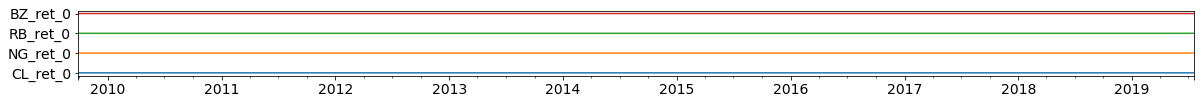

In [57]:
exp.plot_non_na_cols(rets.resample("1D").sum())

In [59]:
# Resample to 1min.
_LOG.info("## Before resampling")
exp.report_zero_null_stats(rets)

## Before resampling
index in [2009-09-27 18:00:00, 2019-07-19 16:59:00]
num_rows=5,158,020


,CL_ret_0,NG_ret_0,RB_ret_0,BZ_ret_0
2009-09-27 18:00:00,NaN,NaN,NaN,NaN
2009-09-27 18:01:00,0.0031746,-0.00126103,NaN,NaN
...,...,...,...,...
2019-07-19 16:58:00,-0.00071518,0,-0.000540979,NaN
2019-07-19 16:59:00,0.000357846,0,NaN,-0.000318218


,num_nulls,pct_nulls [%],num_zeros,pct_zeros [%]
CL_ret_0,1769603,34.31,736090,14.27
NG_ret_0,2592257,50.26,741705,14.38
RB_ret_0,3327179,64.5,140218,2.72
BZ_ret_0,4155865,80.57,131432,2.55


## After resampling
index in [2009-09-27 18:00:00, 2019-07-19 16:59:00]
num_rows=5,158,020


,CL_ret_0,NG_ret_0,RB_ret_0,BZ_ret_0
2009-09-27 18:00:00,NaN,NaN,NaN,NaN
2009-09-27 18:01:00,0.0031746,-0.00126103,NaN,NaN
...,...,...,...,...
2019-07-19 16:58:00,-0.00071518,0,-0.000540979,NaN
2019-07-19 16:59:00,0.000357846,0,NaN,-0.000318218


,num_nulls,pct_nulls [%],num_zeros,pct_zeros [%]
CL_ret_0,1769603,34.31,736090,14.27
NG_ret_0,2592257,50.26,741705,14.38
RB_ret_0,3327179,64.5,140218,2.72
BZ_ret_0,4155865,80.57,131432,2.55


In [ ]:
rets = fin.resample_1min(rets)

_LOG.info("## After resampling")
exp.report_zero_null_stats(rets_tmp)

rets.fillna(0.0, inplace=True)

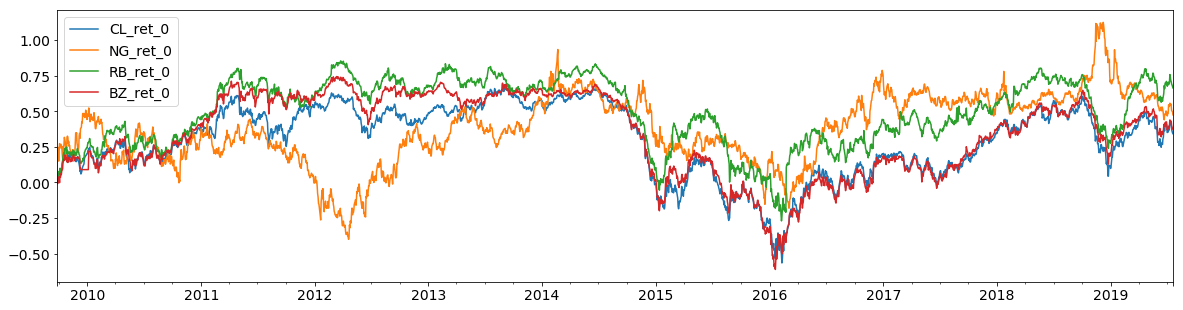

In [60]:
rets.resample("1B").sum().cumsum().plot()

In [ ]:
annot = True
stocks_corr = rets.corr()

sns.clustermap(stocks_corr, annot=annot)

# Analysis

In [ ]:
display(rets.dropna().head(3))
display(feat_data_sampled.dropna().head(3))

In [ ]:
all_df = pd.concat([rets, feat_data_sampled], axis=1, sort=True)

if config["feat_zscore_com"] is not None:
    _LOG.info("z-scoring")
    cols = [c for c in all_df.columns if not c.endswith("_ret_0")]
    _LOG.info("cols=%s", cols)
    all_df[cols] = fin.zscore(
        all_df[cols],
        com=config["feat_zscore_com"],
        demean=True,
        standardize=True,
        delay=1)

all_df.dropna().tail()

In [ ]:
y_var = "CL_ret_0"
#y_var = "NG_ret_0"
x_vars = "demand inventory supply".split()
#use_intercept = True
use_intercept = False
nan_mode = "drop"
#x_shifts = [0]
x_shifts = [-5, -3, -2, -1, 0, 1, 2, 3, 5]
#x_shifts = [-5, -3, -2, -1, 0]
res_df = ana.analyze_features(
    all_df, y_var, x_vars, use_intercept, nan_mode=nan_mode, x_shifts=x_shifts)
display(res_df)

In [ ]:
ar = ana.Reporter(res_df)
ar.plot()

In [ ]:
if False:
    y_var = "CL_ret_0"
    y_var = "NG_ret_0"
    x_vars = "demand"
    #use_intercept = True
    use_intercept = False
    nan_mode = "drop"
    x_shift = 1
    report_stats = True
    res_df = ana._analyze_feature(all_df, y_var, x_var, use_intercept,
                                  nan_mode, x_shift, report_stats)
    display(res_df)